In [ ]:
import numpy as np
from numpy import nan as na
import pandas as pd
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
import math

#from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error as mse

In [ ]:
import requests
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

Load DATA PROVIDED USING GOOGLE DRIVE

In [ ]:
tdf = read_csv('Train.csv')
df = read_csv('Test.csv')
ss = read_csv('SampleSubmission.csv')

APPEND TEST TO TRAIN SET

In [ ]:
df['test'] = 0
tdf['close'] = np.nan

tdf['test'] = 1
df = df.append(tdf)
df['pred'] = 0
df['test'].value_counts()

0    12632
1     6222
Name: test, dtype: int64

In [ ]:
df.head(2)

,id,asset_id,open,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_volume,percent_change_24h,market_cap_global,close,test,pred
0,ID_322qz6,1,9422.849081,9428.490628,9422.849081,7.131986e+08,1.737635e+11,1689.0,817.0,55.0,105.0,61.0,271.0,3420.0,1671.0,11675867.0,39.0,1343.0,448.0,2237.0,124.0,330.0,331.0,2515.0,120.0,506133.0,1326610.0,1159677.0,8406185.0,281329.0,11681999.0,3.6,69.0,2.7,3.6,3.3,66.0,0.007118,1.0,606.0,2.0,1.0,1.0,2.0,5.0,4422,1.434516,2.818066e+11,9428.279323,0,0
1,ID_3239o9,1,7985.359278,7992.059917,7967.567267,4.004755e+08,1.426942e+11,920.0,544.0,20.0,531.0,103.0,533.0,1491.0,242.0,5917814.0,195.0,1070.0,671.0,3888.0,1.0,52.0,315.0,1100.0,23.0,1320.0,381117.0,1706376.0,3754815.0,80010.0,5924770.0,3.7,1.0,2.0,2.0,1.0,43.5,0.009419,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2159,-2.459507,2.126897e+11,7967.567267,0,0
2,ID_323J9k,1,49202.033778,49394.593518,49068.057046,3.017729e+09,9.166977e+11,1446.0,975.0,72.0,1152.0,187.0,905.0,9346.0,4013.0,47778746.0,104.0,2014.0,1099.0,11476.0,331.0,923.0,864.0,6786.0,442.0,9848462.0,5178557.0,2145663.0,25510267.0,5110490.0,47796942.0,3.7,22.0,3.1,3.0,3.3,65.5,0.013530,1.0,692.0,3.0,1.0,1.0,NaN,NaN,10602,4.942448,1.530712e+12,49120.738484,0,0
3,ID_323y5P,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,424.0,268.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285,NaN,NaN,NaN,0,0
4,ID_324kJH,1,10535.737119,10535.737119,10384.798216,1.150053e+09,1.921183e+11,1012.0,638.0,24.0,42.0,50.0,173.0,3262.0,1652.0,14422172.0,21.0,511.0,190.0,2284.0,86.0,280.0,443.0,2284.0,169.0,311017.0,1977833.0,731277.0,10964321.0,440730.0,14426405.0,3.7,22.0,4.7,3.8,4.4,83.0,0.010332,1.0,749.0,2.0,1.0,1.0,NaN,2.0,3996,2.609576,3.386925e+11,10384.798216,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,ID_zufSPk,1,8266.942912,8266.942912,8259.796103,3.100637e+08,1.491229e+11,618.0,438.0,15.0,202.0,42.0,164.0,996.0,262.0,3310472.0,19.0,217.0,135.0,715.0,2.0,25.0,273.0,671.0,25.0,987.0,187128.0,1174018.0,1933268.0,16157.0,3318645.0,3.7,3.0,2.4,2.3,3.9,61.5,0.007076,1.0,921.0,2.0,1.0,1.0,NaN,NaN,1494,-0.967973,2.262125e+11,NaN,1,0
6218,ID_zuz9yf,1,10869.612767,10873.493490,10865.827625,6.989360e+08,2.011601e+11,1608.0,911.0,84.0,204.0,45.0,123.0,5994.0,3808.0,30985192.0,219.0,3020.0,1416.0,7673.0,196.0,502.0,605.0,4484.0,207.0,14614866.0,1739950.0,2052440.0,12246575.0,343689.0,30999455.0,3.7,31.0,2.9,3.9,3.0,67.5,0.005486,1.0,807.0,2.0,1.0,1.0,NaN,6.0,7065,NaN,3.523272e+11,NaN,1,0
6219,ID_zvrMSX,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,139.0,167.0,317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175,NaN,NaN,NaN,1,0
6220,ID_zy9Cfv,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,1,0


FEATURE GENERATION 001

In [ ]:
df['percent_low'] = ((df.low-df.open)/df.open) # pl is percent low
df['percent_high'] = ((df.high-df.open)/df.open) # ph is percent high
df['percent_close'] = ((df.close-df.open)/df.open) # pc is percent close; which might be a more suitable target value but lets see as it goes
df['percent_mid'] = (df.pl * 0.5) + (df.ph * 0.5) # pmid is percent mid

df['percent_change_24h']/=100
df['est24'] = (df.open * df.percent_change_24h)+df.open # estimated 24 hour value
df['p24'] = df.open * ((df.percent_change_24h/24)+1) # prediction using 24 hour value

SCALE MARKET CAPS A BIT

In [ ]:
df.market_cap/=1 000 000 000
df.market_cap_global/=1 000 000 000

DROP SOCIAL MEDIA COLUMNS

In [ ]:
df = df[df.columns.drop(list(df.filter(regex='tweet')))]
df = df[df.columns.drop(list(df.filter(regex='reddit')))]
df = df[df.columns.drop(list(df.filter(regex='url')))]
df = df[df.columns.drop(list(df.filter(regex='social')))]
df = df[df.columns.drop(list(df.filter(regex='asset')))]
df = df[df.columns.drop(list(df.filter(regex='volume')))]
df = df[df.columns.drop(list(df.filter(regex='medium')))]
df = df[df.columns.drop(list(df.filter(regex='sentiment')))]
df = df[df.columns.drop(list(df.filter(regex='youtube')))]

df.columns

Index(['id', 'open', 'high', 'low', 'market_cap', 'news', 'price_score',
       'correlation_rank', 'galaxy_score', 'volatility', 'market_cap_rank',
       'percent_change_24h_rank', 'percent_change_24h', 'market_cap_global',
       'close', 'test', 'pred', 'pl', 'ph', 'pc', 'pmid', 'est24', 'p24'],
      dtype='object')

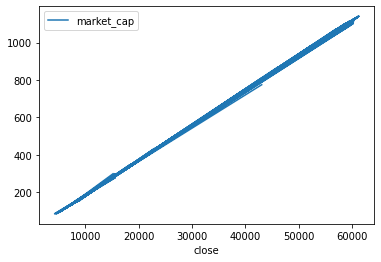

In [ ]:
df.plot('close','market_cap')
df.title()

##### This shows that the close and market_cap are strongly correlated

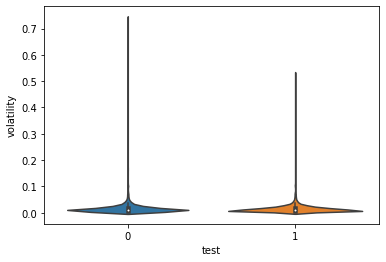

In [ ]:
sns.violinplot(data=df, x='test', y='volatility')
plt.show()

This shows the volatility of train and test data

In [ ]:
fincols = ['open','low','high','close'] # CREATE LIST OF FINANCIAL FEATURES

In [ ]:
df['mid'] = (df['high'] * 0.5) + (df['low']* 0.5) 
df['midround'] = df.mid.round(5) 
print((df.midround.value_counts()==1).value_counts())
df.midround.value_counts()

True     12777
False       68
Name: midround, dtype: int64


8954.61649     10
46359.47647     2
8508.25091      2
8522.74639      2
47755.51557     2
               ..
59287.60263     1
7285.43926      1
6622.30389      1
10982.48634     1
15671.85635     1
Name: midround, Length: 12845, dtype: int64

In [ ]:
df.sort_values(['mid','market_cap'], inplace=True)
fincols+=['mid','market_cap']

In [ ]:
df['diff'] = (df['high'] - df['low']) 

df['highdiff'] = df['percent_high'] - df['percent_low'] # high diff 

MORE FEATURE GENERATION

In [ ]:
df['cm'] = df.close / df.mid

df['mo'] = df.mid / df.open # MO IS MID DIV BY OPEN
df['ol'] = df.open / df.low
df['ho'] = df.high / df.open
df['hm'] = df.high / df.mid
df['hl'] = df.high / df.low
df['mr'] = df.market_cap / df.market_cap_global # MR IS MARKET RATIO


fincols +=['cm']

df.corr().abs()['pc'].sort_values(ascending=False).head(20)

pc                         1.000000
pmid                       0.931170
mo                         0.931170
cm                         0.902338
ho                         0.682874
ph                         0.682874
pl                         0.627032
ol                         0.626092
percent_change_24h         0.139140
percent_change_24h_rank    0.097345
volatility                 0.054779
diff                       0.051866
highdiff                   0.047605
price_score                0.032475
close                      0.032233
hl                         0.031795
market_cap_global          0.030247
market_cap                 0.030183
est24                      0.030106
high                       0.028556
Name: pc, dtype: float64

FEATURE GENERATION 002

In [ ]:
df['meanmo'] =  df[['mid','open']].mean(axis=1) # MEAN OF MID AND OPEN

df['predmo'] = df.open * df.mo  # PREDICTION USING MO FEATURE
df['predol'] = df.open * df.ol  # PREDICTION USING OL FEATURE
df['predho'] = df.open * df.ho
df['predhl'] = df.open * df.hl
df['predmr'] = df.open * df.mr
df['predhm'] = df.open * df.hm
df['predmeanmo'] = df.open * df.meanmo

FILL UP ALREADY READY EXISTING CLOSE VALUES FROM TRAIN SET



In [ ]:
df['closeup'] = df.groupby('high')['close'].transform('mean') # creating aggreate feature

In [ ]:
df.test.value_counts()

0    12632
1     6222
Name: test, dtype: int64

MORE FEATURE GENERATION

In [ ]:
# OPTIONS A, B, C, D, E CORRESPOND TO 5 DIFFERENT STATES OF EACH ROW
df['a'] = (df.high>df.open).astype('int') # HIGH GREATER THAN LOW?
df['b'] = (df.low>df.open).astype('int')
df['c'] = (df.high==df.open).astype('int')
df['d'] = (df.low==df.open).astype('int')
df['e'] = (df.mid>df.open).astype('int') # MID GREATER THAN OPEN?

df['cil'] = (df.close==df.low).astype('int') # CLOSE IS EQUAL TO LOW?
df['cih'] = (df.close==df.high).astype('int') # CLOSE IS EQUAL TO HIGH? NOT REALLY USEFUL FOR TRAINING

df.cil.value_counts()

0    16465
1     2389
Name: cil, dtype: int64

In [ ]:
df[fincols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18854 entries, 7140 to 6220
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        12921 non-null  float64
 1   low         12921 non-null  float64
 2   high        12921 non-null  float64
 3   close       8617 non-null   float64
 4   mid         12921 non-null  float64
 5   market_cap  12570 non-null  float64
 6   cm          8617 non-null   float64
dtypes: float64(7)
memory usage: 1.2 MB


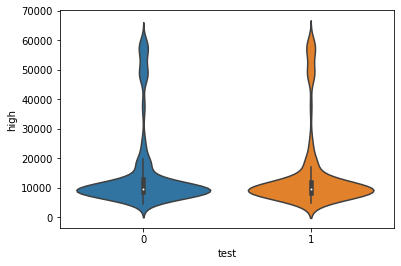

In [ ]:
import seaborn as sns
sns.violinplot(data=df, x='test', y='high')
plt.show()

In [ ]:
train_df = df[df.test==0]
train_df = train_df[train_df['close'].notna()]

train_df = train_df[train_df.close <= train_df.high]
train_df = train_df[train_df.close >= train_df.low]

test_df = df[df.test==1]

COLUMNS TO EXCLUDE COMPLETELY FROM TRAINING

In [ ]:
target_cols = ['id','test','pred','close','closeup','cil','cih','percent_close','cm','news','galaxy_score', 'volatility','correlation_rank']

CREATE LOCAL VALIDATION.

PLS NOTE THAT THE SEED FOR SCALING IS SET HERE. 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(target_cols, axis=1), train_df.close, test_size=0.33 , random_state=77) # SEED IS 77
X = df.drop(target_cols, axis=1)

df_test = test_df.fillna(0)
df_test.drop(target_cols, axis=1, inplace=True)
df_y = train_df.close
train_df.drop(target_cols, axis=1, inplace=True)

USE MORE UNIQUE FEATURES TO TRAIN MODEL

In [ ]:
cols =['open', 'predmeanmo', 'market_cap_global', 'e', 'percent_change_24h' ,'p24' ,'ho' ,'mo' ,'mid', 'market_cap', 'predmr' ,'mr'] 

In [ ]:
X_train, X_val,train_df, df_test = X_train[cols], X_val[cols],train_df[cols], df_test[cols]

In [ ]:
X_train.fillna(0, inplace=True) # FILL NA VALUES WITH ZERO 
X_val.fillna(0, inplace=True)
train_df.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

CREATE POLYNOMIAL FEATURES

In [ ]:
pf = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)

X_train = pf.fit_transform(X_train) # FIT USING X_TRAIN
X_val = pf.transform(X_val)
train_df = pf.transform(train_df)
df_test = pf.transform(df_test)

SCALE FEATURES

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
train_df = sc.transform(train_df)
df_test = sc.transform(df_test)

FIT MODEL TO WHOLE TRAIN SET

In [ ]:
model = Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
model.fit(X_train,y_train)
pred_val = model.predict(X_val)

model.fit(train_df,df_y)
                    
print('LOCAL VALIDATION SCORE IS',mse(pred_val, y_val) ** 0.5 )

# LOCAL VALIDATION SCORE 

LOCAL VALIDATION SCORE IS 46.954326791966494


In [ ]:
# print out the model
model

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
test_df['pred'] = model.predict(df_test)
test_df.fillna(0, inplace=True)
test_df.closeup[test_df.closeup<=0] = np.nan
test_df.pred = test_df.closeup.fillna(test_df.pred)
test_df.pred

4543     4959.059726
5342     4956.378818
2226     5032.139063
634      4956.568211
2177     5051.231528
            ...     
6200   -97424.747928
6209   -97424.747928
6211   -97425.298709
6219   -97425.298709
6220   -97424.872928
Name: pred, Length: 6222, dtype: float64

In [ ]:
print(test_df[test_df['pred']<test_df['low']][['pred','low']])
print(test_df[test_df['pred']>test_df['high']][['pred','high']])

              pred          low
634    4956.568211  4964.729531
1364   5181.437581  5182.336416
6085   5285.077961  5290.131718
4918   5287.802981  5294.300621
3931   5312.186852  5317.230495
...            ...          ...
6200 -97424.747928     0.000000
6209 -97424.747928     0.000000
6211 -97425.298709     0.000000
6219 -97425.298709     0.000000
6220 -97424.872928     0.000000

[2411 rows x 2 columns]
              pred          high
2955   6670.517681   6669.943649
1197   6680.970043   6680.455550
5096   6876.489779   6876.316378
5138   6880.254380   6880.057284
696    6911.373273   6911.290020
...            ...           ...
4264  58604.408190  58553.199486
3090  58931.565999  58912.510948
6212  59267.047491  59107.687709
5465  59524.126846  59418.947444
2334  59204.718186  59186.626946

[651 rows x 2 columns]


In [ ]:
test_df.pred.min()

-97425.29870937073

In [ ]:
test_df

,id,open,high,low,market_cap,news,price_score,correlation_rank,galaxy_score,volatility,market_cap_rank,percent_change_24h_rank,percent_change_24h,market_cap_global,close,test,pred,pl,ph,pc,pmid,est24,p24,mid,midround,diff,highdiff,cm,mo,ol,ho,hm,hl,mr,meanmo,predmo,predol,predho,predhl,predmr,predhm,predmeanmo,closeup,a,b,c,d,e,cil,cih
4543,ID_LXNYkx,4910.805430,4981.827827,4910.805430,90.764185,1.0,3.6,3.2,72.0,0.029968,1.0,796.0,-0.061910,140.876640,0.0,1,4959.059726,0.000000,0.014462,0.0,0.007231,4606.775994,4898.137537,4946.316628,4946.31663,71.022397,0.014462,0.0,1.007231,1.000000,1.014462,1.007179,1.014462,0.644281,4928.561029,4946.316628,4910.805430,4981.827827,4981.827827,3163.940126,4946.061682,2.420320e+07,NaN,1,0,0,1,1,0,0
5342,ID_ex74iW,4966.687792,5011.316612,4897.817082,89.733703,4.0,3.2,3.2,71.0,0.048040,1.0,666.0,-0.051734,139.534261,0.0,1,4956.378818,-0.013867,0.008986,0.0,-0.002440,4709.742528,4955.981739,4954.566847,4954.56685,113.499530,0.022852,0.0,0.997560,1.014062,1.008986,1.011454,1.023173,0.643094,4960.627320,4954.566847,5036.526928,5011.316612,5081.783297,3194.049135,5023.576391,2.463789e+07,NaN,1,0,0,0,0,0,0
2226,ID_3uEVVf,4941.090176,5115.378002,4901.873477,91.354661,10.0,2.8,3.3,69.0,0.046185,1.0,747.0,-0.066633,141.806363,0.0,1,5032.139063,-0.007937,0.035273,0.0,0.013668,4611.849424,4927.371811,5008.625740,5008.62574,213.504525,0.043210,0.0,1.013668,1.008000,1.035273,1.021314,1.043556,0.644221,4974.857958,5008.625740,4980.620622,5115.378002,5156.302812,3183.154892,5046.403007,2.458122e+07,NaN,1,0,0,0,1,0,0
634,ID_3HD4ZQ,5075.294727,5075.294727,4964.729531,91.992257,2.0,3.2,2.8,69.0,0.161403,1.0,900.0,-0.348506,139.620928,0.0,1,4956.568211,-0.021785,0.000000,0.0,-0.010892,3306.522589,5001.595888,5020.012129,5020.01213,110.565196,0.021785,0.0,0.989108,1.022270,1.000000,1.011012,1.022270,0.658872,5047.653428,5020.012129,5188.322225,5075.294727,5188.322225,3343.967298,5131.186121,2.561833e+07,NaN,0,0,1,0,0,0,0
2177,ID_3tJme2,5193.014280,5193.014280,5025.456965,93.884640,2.0,2.3,2.5,63.0,0.145317,1.0,1007.0,-0.154423,144.848791,0.0,1,5051.231528,-0.032266,0.000000,0.0,-0.016133,4391.092902,5159.600889,5109.235622,5109.23562,167.557315,0.032266,0.0,0.983867,1.033342,1.000000,1.016397,1.033342,0.648156,5151.124951,5109.235622,5366.158242,5193.014280,5366.158242,3365.884335,5278.166697,2.674987e+07,NaN,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,ID_zYeKnc,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1,-97424.747928,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0,0,0,0,0,0,0
6209,ID_zh3st5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1,-97424.747928,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0,0,0,0,0,0,0
6211,ID_zkcPg2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1,-97425.298709,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0,0,0,0,0,0,0
6219,ID_zvrMSX,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1,-97425.298709,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,Na

SET PREDICTIONS LESS THAN LOW TO LOW

SET THOSE GREATER THAN HIGH TO HIGH

SET MISSING HIGH/LLOW TO ZERO



In [ ]:
test_df.pred[(test_df.pred<test_df.low)] = test_df.low
test_df.pred[(test_df.pred>test_df.high)] = test_df.high
test_df.pred[(test_df.open<=0)&(test_df.high<=0)&(test_df.low<=0)] = 0

In [ ]:
print(test_df[test_df['pred']<test_df['low']][['pred','low']])
print(test_df[test_df['pred']>test_df['high']][['pred','high']])

Empty DataFrame
Columns: [pred, low]
Index: []
Empty DataFrame
Columns: [pred, high]
Index: []


In [ ]:
pred = pd.DataFrame()
pred['id'] = test_df['id']
pred['close'] = test_df['pred']


In [ ]:
pred = pd.merge(ss.drop('close',axis=1), pred, on='id', how='left')
pred.to_csv('pred.csv', index=False)
pred

,id,close
0,ID_323Sn2,0.000000
1,ID_325SNW,11350.253693
2,ID_325uzE,6305.156395
3,ID_328qCx,0.000000
4,ID_3293uJ,0.000000
...,...,...
6217,ID_zufSPk,8259.796103
6218,ID_zuz9yf,10873.493490
6219,ID_zvrMSX,0.000000
6220,ID_zy9Cfv,0.000000


In [ ]:
pred[pred.close.isna()]

,id,close


In [ ]:
pred.close.value_counts()

0.000000        1918
8947.227578        3
47740.941769       2
8691.003099        2
17967.443232       1
                ... 
19410.531222       1
58455.599115       1
11405.794589       1
9646.322657        1
7274.109723        1
Name: close, Length: 4301, dtype: int64